# Forecasting Pay

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# data path to be used in forecasting
earnings_data_path = '../data/earnings_with_week_number.csv'

earnings_df = pd.read_csv(earnings_data_path)

In [6]:
# 2025 holidays
holidays_2025_path = '../data/holidays_2025.csv'

holidays_2025 = pd.read_csv(holidays_2025_path)

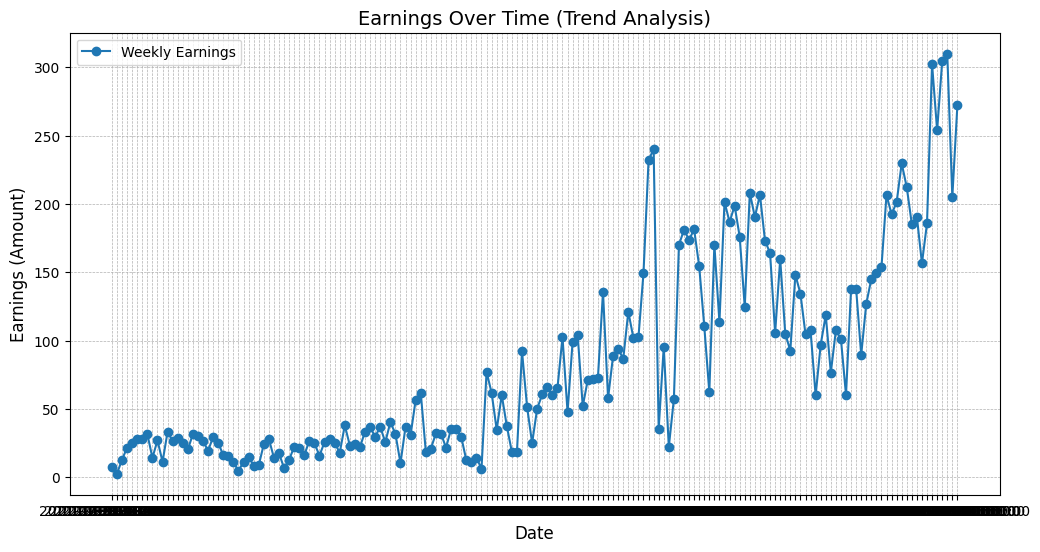

In [3]:
# Plot earnings over time to visualize trends
plt.figure(figsize=(12, 6))
plt.plot(earnings_df['Start_Date'], earnings_df['Amount'], marker='o', label='Weekly Earnings')
plt.title('Earnings Over Time (Trend Analysis)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Earnings (Amount)', fontsize=12)
plt.grid(linestyle='--', linewidth=0.5)
plt.legend()
plt.show()


- #### Using Baseline Prediction (Mean Absolute Error -- MAE)

In [4]:
# Baseline Model: Predict next week's earnings as the previous week's earnings
earnings_df['Baseline_Prediction'] = earnings_df['Amount'].shift(1)

# Remove the first row (NaN in prediction)
earnings_df = earnings_df.dropna().reset_index(drop=True)

# Calculate prediction error
earnings_df['Error'] = abs(earnings_df['Amount'] - earnings_df['Baseline_Prediction'])

# Evaluate the baseline model using Mean Absolute Error (MAE)
baseline_mae = earnings_df['Error'].mean()

print(f"Baseline Model MAE: {baseline_mae:.2f}")

Baseline Model MAE: 24.15


- #### ARIMA Model Prediction

In [ ]:
# Step 1: Prepare the data for ARIMA
# Ensure Start_Date is in datetime format
earnings_df['Start_Date'] = pd.to_datetime(earnings_df['Start_Date'])
# Use the Amount column as the time series
earnings_series = earnings_df['Amount']

# Step 2: Fit an ARIMA model
# We'll use (p=1, d=1, q=1) as initial parameters for simplicity
arima_model = ARIMA(earnings_series, order=(1, 1, 1))
arima_result = arima_model.fit()

# Step 3: Print the summary of the ARIMA model
print(arima_result.summary())

# Step 4: Predict future values (2025 earnings)
# Forecast the next 52 weeks (for 2025)
forecast_steps = 52
forecast = arima_result.get_forecast(steps=forecast_steps)
forecast_values = forecast.predicted_mean

# Confidence intervals for the forecast
forecast_conf_int = forecast.conf_int()

# Step 5: Create a DataFrame for the forecasted values
# Generate forecast dates starting from one week after the last Start_Date
forecast_dates = pd.date_range(start=earnings_df['Start_Date'].iloc[-1] + pd.Timedelta(days=7),
                                periods=forecast_steps, freq='W-FRI')

# Create the forecast DataFrame
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Forecasted_Earnings': forecast_values,
    'Lower_CI': forecast_conf_int.iloc[:, 0],
    'Upper_CI': forecast_conf_int.iloc[:, 1]
})

# Display the forecasted values
# import ace_tools as tools; tools.display_dataframe_to_user(name="Forecasted Earnings for 2025", dataframe=forecast_df)

                               SARIMAX Results                                
Dep. Variable:                 Amount   No. Observations:                  167
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -818.986
Date:                Fri, 20 Dec 2024   AIC                           1643.971
Time:                        18:14:31   BIC                           1653.307
Sample:                             0   HQIC                          1647.761
                                - 167                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2692      0.118      2.288      0.022       0.039       0.500
ma.L1         -0.7572      0.072    -10.581      0.000      -0.897      -0.617
sigma2      1126.1770     81.772     13.772      0.0

ModuleNotFoundError: No module named 'ace_tools'

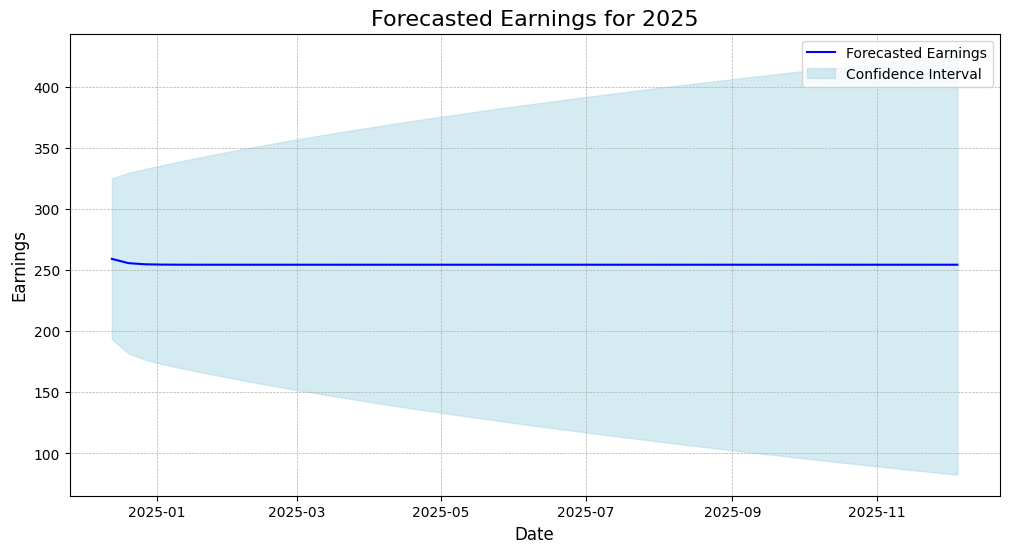

In [7]:
# Plot the forecast with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(forecast_df['Date'], forecast_df['Forecasted_Earnings'], label='Forecasted Earnings', color='blue')
plt.fill_between(
    forecast_df['Date'], 
    forecast_df['Lower_CI'], 
    forecast_df['Upper_CI'], 
    color='lightblue', 
    alpha=0.5, 
    label='Confidence Interval'
)
plt.title('Forecasted Earnings for 2025', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Earnings', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()


In [8]:
# Actual and predicted values for testing
# Replace `-10:` with the range of actual values you want to test
actuals = earnings_df['Amount'][-10:]
predictions = arima_result.predict(start=len(earnings_series)-10, end=len(earnings_series)-1)

# Calculate MAE
mae = mean_absolute_error(actuals, predictions)
print(f"Mean Absolute Error (MAE): {mae:.2f}")


Mean Absolute Error (MAE): 42.02


In [9]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Actual and predicted values for testing
# Replace `-10:` with the range of actual values you want to test
actuals = earnings_df['Amount'][-10:]
predictions = arima_result.predict(start=len(earnings_series)-10, end=len(earnings_series)-1)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actuals, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Root Mean Squared Error (RMSE): 54.39


In [12]:
# Fit ARIMA(2,1,2)
arima_alt_model = ARIMA(earnings_series, order=(2, 1, 2))
arima_alt_result = arima_alt_model.fit()

# Evaluate the alternative ARIMA model
predictions_alt = arima_alt_result.predict(start=len(earnings_series)-10, end=len(earnings_series)-1)
mae_alt = mean_absolute_error(actuals, predictions_alt)
rmse_alt = np.sqrt(mean_squared_error(actuals, predictions_alt))

print(f"ARIMA(2,1,2) MAE: {mae_alt:.2f}")
print(f"ARIMA(2,1,2) RMSE: {rmse_alt:.2f}")


ARIMA(2,1,2) MAE: 42.01
ARIMA(2,1,2) RMSE: 54.39


In [13]:
# Fit SARIMA model with seasonality (52-week cycle)
sarima_model = SARIMAX(earnings_series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))
sarima_result = sarima_model.fit()

# Evaluate SARIMA model
predictions_sarima = sarima_result.predict(start=len(earnings_series)-10, end=len(earnings_series)-1)
mae_sarima = mean_absolute_error(actuals, predictions_sarima)
rmse_sarima = np.sqrt(mean_squared_error(actuals, predictions_sarima))

print(f"SARIMA MAE: {mae_sarima:.2f}")
print(f"SARIMA RMSE: {rmse_sarima:.2f}")

c:\Users\aspec\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\aspec\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA MAE: 41.04
SARIMA RMSE: 54.45


In [17]:
# Add holiday flags to the DataFrame
earnings_df['Holiday_Flag'] = earnings_df['Start_Date'].isin(holidays_2025['Date']).astype(int)

# Fit SARIMAX with exogenous variable (holiday flag)
sarimax_model = SARIMAX(earnings_series, order=(1, 1, 1), exog=earnings_df['Holiday_Flag'])
sarimax_result = sarimax_model.fit()

# Evaluate SARIMAX model
predictions_sarimax = sarimax_result.predict(start=len(earnings_series)-10, end=len(earnings_series)-1,
                                             exog=earnings_df['Holiday_Flag'][-10:])
mae_sarimax = mean_absolute_error(actuals, predictions_sarimax)
rmse_sarimax = np.sqrt(mean_squared_error(actuals, predictions_sarimax))

print(f"SARIMAX MAE: {mae_sarimax:.2f}")
print(f"SARIMAX RMSE: {rmse_sarimax:.2f}")

SARIMAX MAE: 42.02
SARIMAX RMSE: 54.39


In [5]:
# Define 2025 holidays (manually or load from a CSV)
holidays_2025 = [
    '2025-01-01', '2025-01-20', '2025-02-17', '2025-04-18', '2025-04-20', 
    '2025-04-21', '2025-05-05', '2025-05-26', '2025-07-04', '2025-08-25', 
    '2025-09-01', '2025-11-27', '2025-12-25', '2025-12-26'
]
holidays_2025 = pd.to_datetime(holidays_2025)

# Create a DataFrame for all weeks of 2025
forecast_dates = pd.date_range(start='2025-01-03', periods=52, freq='W-FRI')
forecast_holiday_flags = forecast_dates.isin(holidays_2025).astype(int)

forecast_exog = pd.DataFrame({
    'Date': forecast_dates,
    'Holiday_Flag': forecast_holiday_flags
})

In [4]:
# Create weekly periods for 2025
forecast_dates = pd.date_range(start='2025-01-03', periods=52, freq='W-FRI')

# Function to check if a holiday exists within a week
def has_holiday(start, end, holiday_dates):
    return any((holiday_dates >= start) & (holiday_dates <= end))

# Generate Holiday_Flag for each week
forecast_holiday_flags = []
for date in forecast_dates:
    week_start = date - pd.Timedelta(days=6)
    week_end = date
    forecast_holiday_flags.append(
        has_holiday(week_start, week_end, holidays_2025['Date'])
    )

# Create the DataFrame
forecast_exog = pd.DataFrame({
    'Date': forecast_dates,
    'Holiday_Flag': forecast_holiday_flags
})
forecast_exog['Holiday_Flag'] = forecast_exog['Holiday_Flag'].astype(int)

TypeError: '>=' not supported between instances of 'str' and 'Timestamp'

In [7]:
# Fit SARIMAX model with historical data
earnings_df['Holiday_Flag'] = earnings_df['Start_Date'].isin(holidays_2025['Date']).astype(int)
sarimax_model = SARIMAX(
    earnings_df['Amount'], 
    order=(1, 1, 1), 
    exog=earnings_df['Holiday_Flag']
)
sarimax_result = sarimax_model.fit()

# Predict for 2025 using holiday flags
forecast_2025 = sarimax_result.get_forecast(steps=52, exog=forecast_exog['Holiday_Flag'])
forecast_values = forecast_2025.predicted_mean
forecast_conf_int = forecast_2025.conf_int()

# Create DataFrame for predictions
forecast_df = pd.DataFrame({
    'Date': forecast_exog['Date'],
    'Forecasted_Earnings': forecast_values,
    'Lower_CI': forecast_conf_int.iloc[:, 0],
    'Upper_CI': forecast_conf_int.iloc[:, 1],
    'Holiday_Flag': forecast_exog['Holiday_Flag']
})

forecast_df
# Save to CSV
# forecast_df.to_csv('earnings_forecast_2025_with_holidays.csv', index=False)
# print("Forecasted earnings for 2025 saved to 'earnings_forecast_2025_with_holidays.csv'")


,Date,Forecasted_Earnings,Lower_CI,Upper_CI,Holiday_Flag
0,2025-01-03,NaN,NaN,NaN,0.0
1,2025-01-10,NaN,NaN,NaN,0.0
2,2025-01-17,NaN,NaN,NaN,0.0
3,2025-01-24,NaN,NaN,NaN,0.0
4,2025-01-31,NaN,NaN,NaN,0.0
...,...,...,...,...,...
215,NaT,254.467646,88.638144,420.297148,NaN
216,NaT,254.467646,87.210877,421.724415,NaN
217,NaT,254.467646,85.795687,423.139605,NaN
218,NaT,254.467646,84.392272,424.543020,NaN
